In [1]:
import sys
print sys.prefix
print sys.version
spark_home = "C:\spark152"
db_path = "D:/tmp/IPYNBv2/eds"
# spark_home = "/opt/mapr/spark/spark-1.6.1"
# db_path = "/user/mapr/eds"

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
import drill_utilities as du
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer

In [3]:
import os
print(spark_home)
os.environ['SPARK_HOME'] = spark_home
os.environ['PYSPARK_DRIVER_PYTHON'] ="jupyter"
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']="notebook"
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.8.2.1-src.zip'))
import spark_util as su

C:\spark152


In [4]:
def save_df_as_parquet(df, table_name):
    """
    Save a pandas DataFrame as a Parquet table in the Drill database
    """
    sc = su.SparkClient(spark_home, exec_memory="4g")
    df_src_pd = df
    if 'dt_deces' in df.columns:
        df_src_pd['dt_deces'] = df.dt_deces.apply(str)
    spark_df = sc._sql.createDataFrame(df_src_pd)
    spark_df.write.parquet(db_path+"/"+table_name, mode='overwrite')
    sc._spark_ctx.stop()

# Connection to Drill database

In [5]:
#
# Drillbit ODBC connection
#
conn = du.DrillODBC("drill_eds")

In [6]:
try:
    conn._conn.execute("drop table igs2_matrix1")
    conn._conn.execute("drop table igs2_dataset")
except:
    pass


## Ordering data by SAPS2 form

In [7]:
q1 = "select id_form, lpad(cast(id_nda as VARCHAR),10,'0') as id_nda, champ_formulaire, CAST(LWERT as VARCHAR) as value_field, j1 \
from saps2_forms where champ_formulaire like 'int_esc%' \
        or champ_formulaire in ('int_maladies_chronique', 'int_igs2') \
        order by id_form, id_nda, champ_formulaire"
df1 = conn.df_from_query(q1)
df1.head()

,id_form,id_nda,champ_formulaire,value_field,j1
0,9028131,0000676475,int_esc_admission,0,None
1,9028131,0000676475,int_esc_age,16,None
2,9028131,0000676475,int_esc_bicarbonate,3,None
3,9028131,0000676475,int_esc_bilirubine,0,None
4,9028131,0000676475,int_esc_diurese,0,None


## Retrieve date of entrance in ICU per case
Sometimes, form is filled later ==> in that case, j1 is filled with date of entrance<br>
When form is filled on day one, date of entrance is dt_ins (date of form creation)

In [8]:
q2 = "select distinct id_form, lpad(cast(id_nda as VARCHAR),10,'0') as id_nda, dt_ins, j1 from saps2_forms \
where champ_formulaire like 'int_esc%' \
        or champ_formulaire = 'int_maladies_chronique'"
df2 = conn.df_from_query(q2)
df2['dt_ins'] = pd.to_datetime(df2['dt_ins'])
df2['j1'] = pd.to_datetime(df2['j1'])
df2.head(10)

,id_form,id_nda,dt_ins,j1
0,9028131,0000676475,2012-11-29 18:29:19,NaT
1,9040832,0000676475,2012-11-30 07:28:11,NaT
2,9972417,0000669364,2012-12-13 18:50:32,NaT
3,9972490,0000704443,2012-12-13 18:53:53,NaT
4,9972629,0000706030,2012-12-13 19:04:06,NaT
5,9972555,0000669364,2012-12-13 19:13:09,NaT
6,9973606,0000668052,2012-12-14 00:18:14,NaT
7,9984881,0000738250,2012-12-14 09:14:22,NaT
8,10017517,0000741648,2012-12-15 15:42:50,NaT
9,10030449,0000741967,2012-12-16 07:28:21,NaT


In [9]:
#
# Retrieve the proper date of entrance per case
#
import warnings
warnings.filterwarnings('ignore')

df2.ix[df2['j1'].notnull(), 'dt_ins'] = df2.ix[df2['j1'].notnull(), 'j1']
df2.drop('j1', axis=1, inplace=True)
df2.head(10)

,id_form,id_nda,dt_ins
0,9028131,0000676475,2012-11-29 18:29:19
1,9040832,0000676475,2012-11-30 07:28:11
2,9972417,0000669364,2012-12-13 18:50:32
3,9972490,0000704443,2012-12-13 18:53:53
4,9972629,0000706030,2012-12-13 19:04:06
5,9972555,0000669364,2012-12-13 19:13:09
6,9973606,0000668052,2012-12-14 00:18:14
7,9984881,0000738250,2012-12-14 09:14:22
8,10017517,0000741648,2012-12-15 15:42:50
9,10030449,0000741967,2012-12-16 07:28:21


In [10]:
# in df1 ==> all saps2 values
# in df2 ==> all patient cases
print(len(df1), len(df2))

(273344, 17084)


In [11]:
#
# Create a unique composite key per value :
#
# id_nda+date_of_entrance+'_'+form_id
#
from time import strftime

# merging datasets
result =  pd.merge(df1,df2[['id_form', 'dt_ins']], how='inner', on=['id_form'])
print(len(result))
result.drop('j1', axis=1, inplace=True)
result['id_nda'] = result.id_nda.str.cat(result.dt_ins.dt.strftime('%Y-%m-%d'))
result['id_nda'] = result.id_nda + "_"
result['id_nda'] = result.id_nda.str.cat(result.id_form.astype(str))
result.drop('dt_ins', axis=1, inplace=True)
result.drop('id_form', axis=1, inplace=True)
result.columns = ['id_form_ndaj1', 'champ_formulaire', 'value_field']
result.head(30)

273344


,id_form_ndaj1,champ_formulaire,value_field
0,00006764752012-11-29_9028131,int_esc_admission,0
1,00006764752012-11-29_9028131,int_esc_age,16
2,00006764752012-11-29_9028131,int_esc_bicarbonate,3
3,00006764752012-11-29_9028131,int_esc_bilirubine,0
4,00006764752012-11-29_9028131,int_esc_diurese,0
5,00006764752012-11-29_9028131,int_esc_frequence,0
6,00006764752012-11-29_9028131,int_esc_glasgow,0
7,00006764752012-11-29_9028131,int_esc_globules,0
8,00006764752012-11-29_9028131,int_esc_kaliemie,3
9,00006764752012-11-29_9028131,int_esc_natremie,0


## pivot dataframe to create a matrix

In [12]:
# pivot dataframe to get matrix
result = result.pivot(index='id_form_ndaj1',columns='champ_formulaire', values='value_field')
print(len(result))
result.head()

17084


champ_formulaire,int_esc_admission,int_esc_age,int_esc_bicarbonate,int_esc_bilirubine,int_esc_diurese,int_esc_frequence,int_esc_glasgow,int_esc_globules,int_esc_kaliemie,int_esc_natremie,int_esc_pao2,int_esc_pression,int_esc_temperature,int_esc_uree,int_igs2,int_maladies_chronique
id_form_ndaj1,,,,,,,,,,,,,,,,
00000238542014-11-28_90928817,6,12,0,0,0,0,13,0,0,0,6,5,0,0,42,0
00001400442014-12-09_93078783,6,18,0,0,0,0,0,0,0,0,0,0,0,0,24,0
00001791912013-08-05_25042009,6,16,3,0,4,4,5,3,0,0,6,13,0,6,66,0
00003433032013-12-02_34801126,6,12,3,0,4,4,0,3,0,0,0,5,0,6,43,0
00003780902016-06-19_308250174,6,18,3,0,11,0,7,0,3,0,0,13,3,6,70,0


In [13]:
# change the index to retrieve our classic composite case id ==>
# id_nda+date_of_entrance

result['id_ndaj1'] = result.index.str.extract('(.*)_.*')
result.head()

champ_formulaire,int_esc_admission,int_esc_age,int_esc_bicarbonate,int_esc_bilirubine,int_esc_diurese,int_esc_frequence,int_esc_glasgow,int_esc_globules,int_esc_kaliemie,int_esc_natremie,int_esc_pao2,int_esc_pression,int_esc_temperature,int_esc_uree,int_igs2,int_maladies_chronique,id_ndaj1
id_form_ndaj1,,,,,,,,,,,,,,,,,
00000238542014-11-28_90928817,6,12,0,0,0,0,13,0,0,0,6,5,0,0,42,0,00000238542014-11-28
00001400442014-12-09_93078783,6,18,0,0,0,0,0,0,0,0,0,0,0,0,24,0,00001400442014-12-09
00001791912013-08-05_25042009,6,16,3,0,4,4,5,3,0,0,6,13,0,6,66,0,00001791912013-08-05
00003433032013-12-02_34801126,6,12,3,0,4,4,0,3,0,0,0,5,0,6,43,0,00003433032013-12-02
00003780902016-06-19_308250174,6,18,3,0,11,0,7,0,3,0,0,13,3,6,70,0,00003780902016-06-19


In [14]:
# create saps2_nda_tr table (nda_tr reduced to saps2 forms cases)
q_saps2_nda_tr = "drop table saps2_nda_tr"
try:
    conn._conn.execute(q_saps2_nda_tr)
except:
    pass

q_saps2_nda_tr = "create table saps2_nda_tr as \
select * from nda_tr \
where id_nda in (select distinct id_nda from saps2_forms)"
conn._conn.execute(q_saps2_nda_tr)

In [15]:
# create saps2_nda_mouv_ufr_tr table (nda_mouv_ufr_tr reduced to saps2 forms cases)
q_saps2_nda_mouv_ufr_tr = "drop table saps2_nda_mouv_ufr_tr"
try:
    conn._conn.execute(q_saps2_nda_mouv_ufr_tr)
except:
    pass

q_saps2_nda_mouv_ufr_tr = "create table saps2_nda_mouv_ufr_tr as \
select * from nda_mouv_ufr_tr \
where id_nda in (select distinct id_nda from saps2_forms)"
conn._conn.execute(q_saps2_nda_mouv_ufr_tr)

In [16]:
save_df_as_parquet(result, "igs2_matrix1")

In [17]:
#
# create table of mapping : key=case_id  value=id_patient
#
q_map_nda_pat = "drop table map_nda_pat"
try:
    conn._conn.execute(q_map_nda_pat)
except:
    pass

q_map_nda_pat = "create table map_nda_pat as \
select distinct i.id_ndaj1, n.ids_pat, n2.dt_deb_nda, n2.dt_fin_nda \
from igs2_matrix1 i, saps2_nda_mouv_ufr_tr n, saps2_nda_tr n2 \
where lpad(cast(n.id_nda as VARCHAR),10,'0')=SUBSTR(i.id_ndaj1,1,CHAR_LENGTH(i.id_ndaj1)-10) \
and lpad(cast(n2.id_nda as VARCHAR),10,'0')=SUBSTR(i.id_ndaj1,1,CHAR_LENGTH(i.id_ndaj1)-10)"
conn._conn.execute(q_map_nda_pat)

## Enrich matrix with death date

In [18]:
# get dt_deces for all patients found
q = "select m.id_ndaj1, \
case when (m.dt_deb_nda <= p.dt_deces and p.dt_deces<=m.dt_fin_nda) \
    then p.dt_deces else cast(NULL as TIMESTAMP) end as dt_deces \
from map_nda_pat m, patient_tr p \
where m.ids_pat = p.ids_pat"

additional_result = conn.df_from_query(q)

print(len(additional_result))

14033


In [19]:
# join to result
resultf = pd.merge(result, additional_result, how='inner', on=['id_ndaj1'])
print(len(resultf))
resultf.head()

14715


champ_formulaire,int_esc_admission,int_esc_age,int_esc_bicarbonate,int_esc_bilirubine,int_esc_diurese,int_esc_frequence,int_esc_glasgow,int_esc_globules,int_esc_kaliemie,int_esc_natremie,int_esc_pao2,int_esc_pression,int_esc_temperature,int_esc_uree,int_igs2,int_maladies_chronique,id_ndaj1,dt_deces
0,6,12,0,0,0,0,13,0,0,0,6,5,0,0,42,0,00000238542014-11-28,None
1,6,18,0,0,0,0,0,0,0,0,0,0,0,0,24,0,00001400442014-12-09,None
2,6,16,3,0,4,4,5,3,0,0,6,13,0,6,66,0,00001791912013-08-05,None
3,6,12,3,0,4,4,0,3,0,0,0,5,0,6,43,0,00003433032013-12-02,None
4,6,18,3,0,11,0,7,0,3,0,0,13,3,6,70,0,00003780902016-06-19,None


In [20]:
resultf.index = resultf['id_ndaj1']

In [21]:
resultf.head()

champ_formulaire,int_esc_admission,int_esc_age,int_esc_bicarbonate,int_esc_bilirubine,int_esc_diurese,int_esc_frequence,int_esc_glasgow,int_esc_globules,int_esc_kaliemie,int_esc_natremie,int_esc_pao2,int_esc_pression,int_esc_temperature,int_esc_uree,int_igs2,int_maladies_chronique,id_ndaj1,dt_deces
id_ndaj1,,,,,,,,,,,,,,,,,,
00000238542014-11-28,6,12,0,0,0,0,13,0,0,0,6,5,0,0,42,0,00000238542014-11-28,None
00001400442014-12-09,6,18,0,0,0,0,0,0,0,0,0,0,0,0,24,0,00001400442014-12-09,None
00001791912013-08-05,6,16,3,0,4,4,5,3,0,0,6,13,0,6,66,0,00001791912013-08-05,None
00003433032013-12-02,6,12,3,0,4,4,0,3,0,0,0,5,0,6,43,0,00003433032013-12-02,None
00003780902016-06-19,6,18,3,0,11,0,7,0,3,0,0,13,3,6,70,0,00003780902016-06-19,None


In [22]:
# Total number of SAPS2 forms
len(resultf)

14715

In [23]:
# mortality rate
mr = float(resultf[resultf['dt_deces'].notnull()].shape[0]) / float(resultf.shape[0]) * 100.
print("Mortality rate: {}".format(mr))

Mortality rate: 13.3401291199


## Enrich with SAPS2 logit and probability of mortality

In [24]:
# compute logit and SAPS2 mortality probability
# Logit = -7.7631+0.0737*IGS2+0.9971*log(IGS2+1)
# Probabilité =e(Logit)/(1+e(Logit))
resultf['logit'] = -7.7631+0.0737*resultf['int_igs2'].astype('float') + 0.9971*np.log(resultf['int_igs2'].astype('float')+1.)
resultf['pr'] = np.exp(resultf['logit']) / (1. + np.exp(resultf['logit']))

### APHP alarm threshold
At APHP, an alarm is triggered when SAPS2 is higher or equal 15<br>
Compute related probability threshold

In [25]:
logit = -7.7631+0.0737*15. + 0.9971*np.log(16.)
pr = np.exp(logit) / (1. + np.exp(logit))
pr

0.019975877118311187

In [26]:
resultf.head()

champ_formulaire,int_esc_admission,int_esc_age,int_esc_bicarbonate,int_esc_bilirubine,int_esc_diurese,int_esc_frequence,int_esc_glasgow,int_esc_globules,int_esc_kaliemie,int_esc_natremie,int_esc_pao2,int_esc_pression,int_esc_temperature,int_esc_uree,int_igs2,int_maladies_chronique,id_ndaj1,dt_deces,logit,pr
id_ndaj1,,,,,,,,,,,,,,,,,,,,
00000238542014-11-28,6,12,0,0,0,0,13,0,0,0,6,5,0,0,42,0,00000238542014-11-28,None,-0.917407,0.285486
00001400442014-12-09,6,18,0,0,0,0,0,0,0,0,0,0,0,0,24,0,00001400442014-12-09,None,-2.784759,0.058153
00001791912013-08-05,6,16,3,0,4,4,5,3,0,0,6,13,0,6,66,0,00001791912013-08-05,None,1.293599,0.784756
00003433032013-12-02,6,12,3,0,4,4,0,3,0,0,0,5,0,6,43,0,00003433032013-12-02,None,-0.820785,0.305597
00003780902016-06-19,6,18,3,0,11,0,7,0,3,0,0,13,3,6,70,0,00003780902016-06-19,None,1.646218,0.838379


## Save dataframe as Parquet Table

In [27]:
save_df_as_parquet(resultf, "igs2_dataset")

In [32]:
print(len(resultf[(resultf['dt_deces']!='None') & (resultf['dt_deces'].notnull())]))
print(len(resultf))

1963
14715


In [61]:
resultf = conn.df_from_query("select * from igs2_dataset")
logit = -7.7631+0.0737*15. + 0.9971*np.log(16.)
pr = np.exp(logit) / (1. + np.exp(logit))
pr
# mortality rate
mr = float(resultf[(resultf['dt_deces']!='None') & (resultf['dt_deces'].notnull())].shape[0]) / float(resultf.shape[0]) * 100.
print("Mortality rate: {}".format(mr))

Mortality rate: 13.3401291199


### Prediction with SAPS2 and APHP threshold on the complete dataset

In [62]:
# test score igs2
# y_pred = (resultf['pr'] > 0.4).values
y_pred = (resultf['pr'] > pr).values
y_true = np.logical_not((resultf['dt_deces'].isnull())|(resultf['dt_deces']=='None')).values

In [63]:
y_pred[0:20]

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True], dtype=bool)

In [64]:
y_true[0:20]

array([False, False, False, False, False, False,  True,  True,  True,
       False, False, False, False, False, False,  True, False, False,
       False,  True], dtype=bool)

### Accuracy, recall, precision and AUC with SAPS2 and APHP threshold on the complete dataset

In [65]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score
print(accuracy_score(y_true, y_pred), recall_score(y_true, y_pred), precision_score(y_true, y_pred), \
      roc_auc_score(y_true, resultf['pr']))

(0.26782195039075773, 0.99490575649516044, 0.15357395612172683, 0.85007376106655685)


## Create a dataset for Machine learning

In [66]:
#
# Create dataset
#
vois = ['int_esc_admission', 'int_esc_age', 'int_esc_bicarbonate', 'int_esc_bilirubine', 'int_esc_diurese',
        'int_esc_frequence', 'int_esc_glasgow', 'int_esc_globules', 'int_esc_kaliemie', 'int_esc_natremie',
        'int_esc_pao2', 'int_esc_pression', 'int_esc_temperature', 'int_esc_uree', 'int_maladies_chronique']

kept_features = list(vois)
# kept_features.append('int_igs2')

# Mapping between form vois codes and Orbis reference catalog
voi_map = {
    'int_esc_admission': 'TYPEADMISSION',
    'int_esc_age': 'AGE', 
    'int_esc_bicarbonate': 'BICARBONATEMIE', 
    'int_esc_bilirubine': 'BILIRUBINE', 
    'int_esc_diurese': 'DIURESE',
    'int_esc_frequence': 'FREQUENCECARDIAQUE', 
    'int_esc_glasgow': 'GLASGOW', 
    'int_esc_globules': 'GLOBULESBLANCS', 
    'int_esc_kaliemie': 'KALIEMIE', 
    'int_esc_natremie': 'NATREMIE',
    'int_esc_pao2': 'PAO2/FIO2',
    'int_esc_pression': 'PRESSIONARTERIELLE', 
    'int_esc_temperature': 'TEMPERATURE', 
    'int_esc_uree': 'UREE', 
    'int_maladies_chronique': 'MALADIESCHRONIQUES'
}

X = resultf[kept_features]
X.rename(columns=voi_map, inplace=True)
X.head()

,TYPEADMISSION,AGE,BICARBONATEMIE,BILIRUBINE,DIURESE,FREQUENCECARDIAQUE,GLASGOW,GLOBULESBLANCS,KALIEMIE,NATREMIE,PAO2/FIO2,PRESSIONARTERIELLE,TEMPERATURE,UREE,MALADIESCHRONIQUES
0,6,12,0,0,0,0,13,0,0,0,6,5,0,0,0
1,6,18,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,16,3,0,4,4,5,3,0,0,6,13,0,6,0
3,6,12,3,0,4,4,0,3,0,0,0,5,0,6,0
4,6,18,3,0,11,0,7,0,3,0,0,13,3,6,0


In [68]:
list(X.columns)

['TYPEADMISSION',
 'AGE',
 'BICARBONATEMIE',
 'BILIRUBINE',
 'DIURESE',
 'FREQUENCECARDIAQUE',
 'GLASGOW',
 'GLOBULESBLANCS',
 'KALIEMIE',
 'NATREMIE',
 'PAO2/FIO2',
 'PRESSIONARTERIELLE',
 'TEMPERATURE',
 'UREE',
 'MALADIESCHRONIQUES']

In [39]:
#
# Select all values per voi
#
q = "select PARENT as SAPS2_VARIABLE, LID as SAPS2_INTERVAL, saps2weight, index from \
IGS2_ref_feature_categories order by PARENT, index"
df_categories = conn.df_from_query(q)
df_categories.head()

,SAPS2_VARIABLE,SAPS2_INTERVAL,saps2weight,index
0,AGE,<40,0,1
1,AGE,40-59,7,3
2,AGE,60-69,12,4
3,AGE,70-74,15,5
4,AGE,75-79,16,6


In [439]:
# D0 = X[['MALADIESCHRONIQUES']].transpose().iloc[0].values.tolist()
# D = [{'MALADIESCHRONIQUES': val} for val in D0]
# v = DictVectorizer(sparse=False)
# X_MALADIESCHRONIQUES = v.fit_transform(D).astype(int)
# vocabulary_map = {
#     'MALADIESCHRONIQUES=0': 'NO_CHRONICAL_DISEASE',
#     'MALADIESCHRONIQUES=9': 'METASTATIC_CANCER',
#     'MALADIESCHRONIQUES=10': 'HEMATOLOGIC_MALIGNANCY',
#     'MALADIESCHRONIQUES=17': 'AIDS'
# }
# for k in vocabulary_map.keys():
#     v.vocabulary_[vocabulary_map[k]] = v.vocabulary_.pop(k)
# X_MALADIESCHRONIQUES = pd.DataFrame(X_MALADIESCHRONIQUES, index=X.index, \
#                                     columns=sorted(v.vocabulary_, key=v.vocabulary_.__getitem__))
# X_MALADIESCHRONIQUES.head()

In [440]:
# from pandas.tools.plotting import table

# fig, ax = plt.subplots(figsize=(12, 2)) # set size frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis
# ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
# df = df_categories[['SAPS2_VARIABLE','SAPS2_INTERVAL','saps2weight']]
# tabla = table(ax, df, loc='upper center', colWidths=[0.23, 0.3, 0.1])  # where df is your data frame
# tabla.auto_set_font_size(False) # Activate set fontsize manually
# tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
# tabla.scale(1.2, 1.2) # change size table
# plt.savefig('saps2_var.png', transparent=True)

In [441]:
from sklearn.preprocessing import LabelEncoder

# Create label encoder for each voi
label_encoders = {}
for key in voi_map.keys():
    voi = voi_map[key]
    print(voi)
    # DataFrame restriction
    df_labels = df_categories[df_categories['SAPS2_VARIABLE']==voi]
    le = LabelEncoder()
    list_labels = df_labels['saps2weight'].values.astype('str')
    le.fit(list_labels)
    label_encoders[voi] = le
    X[voi] = le.transform(X[voi].astype('str'))
    
X.head(10)

KALIEMIE
UREE
BILIRUBINE
TYPEADMISSION
GLASGOW
PAO2/FIO2
PRESSIONARTERIELLE
FREQUENCECARDIAQUE
BICARBONATEMIE
AGE
MALADIESCHRONIQUES
TEMPERATURE
NATREMIE
DIURESE
GLOBULESBLANCS


champ_formulaire,TYPEADMISSION,AGE,BICARBONATEMIE,BILIRUBINE,DIURESE,FREQUENCECARDIAQUE,GLASGOW,GLOBULESBLANCS,KALIEMIE,NATREMIE,PAO2/FIO2,PRESSIONARTERIELLE,TEMPERATURE,UREE,MALADIESCHRONIQUES
id_ndaj1,,,,,,,,,,,,,,,
00000238542014-11-28,1,1,0,0,0,0,1,0,0,0,2,3,0,0,0
00001400442014-12-09,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0
00001791912013-08-05,1,3,1,0,2,3,3,2,0,0,2,1,0,2,0
00003433032013-12-02,1,1,1,0,2,3,0,2,0,0,0,3,0,2,0
00003780902016-06-19,1,4,1,0,1,0,4,0,1,0,0,1,1,2,0
00005114282015-03-31,2,1,1,0,1,0,0,0,0,0,0,0,0,2,0
00006680522012-12-14,1,4,1,0,1,0,3,0,0,0,3,1,0,2,0
00006693642012-12-13,2,1,2,0,1,1,2,0,1,0,2,1,0,0,0
00006693642012-12-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [443]:
# X = X.join(X_MALADIESCHRONIQUES)
# # X = X.drop('MALADIESCHRONIQUES', axis=1)
# X.head()

In [40]:
import classif_utilities as cu

In [15]:
# label_encoders['AGE'].inverse_transform([1,2,3,4,5])

In [41]:
# Separate train / validation
X_train, y_train, X_valid, y_valid, valid_indices = cu.split_dataset(X.values, y_true, indices=True)

# Retrieve related validation set from the resultf DataFrame
resultf_valid = resultf.ix[valid_indices, :]
yf_pred = resultf_valid['pr'] > pr

In [42]:
# mortality rate for validation set
mr = float(np.size(np.where(y_valid==True)[0])) / float(np.size(np.where(y_valid==False)[0])) * 100.
print("Mortality rate: {}".format(mr))

Mortality rate: 15.4081392614


### Accuracy, recall, precision and AUC with SAPS2 and APHP threshold on the validation set

In [43]:
print(np.size(y_valid))
print(accuracy_score(y_valid, yf_pred), recall_score(y_valid, yf_pred), precision_score(y_valid, yf_pred), \
      roc_auc_score(y_valid, resultf_valid['pr']))

4906
(0.27068895230330209, 0.99847328244274813, 0.15457338690616876, 0.86066753938453633)


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

clfs = [
    LogisticRegression(penalty='l2', C=0.9),
    CalibratedClassifierCV(SVC()),
    DecisionTreeClassifier(min_samples_leaf=50),
    RandomForestClassifier(min_samples_leaf=50, n_estimators=200, n_jobs=-1),
    xgb.XGBClassifier(max_depth=3, n_estimators=95, min_child_weight=3.7, base_score=0.5, colsample_bytree=0.8,
                           colsample_bylevel=1, subsample=1, scale_pos_weight=1)
#     GradientBoostingClassifier(min_samples_leaf=50, n_estimators=200)
]

labels = [
    'LogisticRegression(penalty=''l2'', C=0.9)',
    'CalibratedClassifierCV(SVC())',
    'DecisionTreeClassifier',
    'RandomForestClassifier',
    'xgboost.XGBClassifier'
]

for i, clf in enumerate(clfs):
    print labels[i]
    print("Cross validation, accuracies")
    print(cu.cross_valid_clf(clf, X_train, y_train))
    print("Validation set ==> accuracy + recall + precision + ROC/AUC score")
    print(cu.validate_clf(clf, X_train, y_train, X_valid, y_valid))
    print

LogisticRegression(penalty=l2, C=0.9)
Cross validation, accuracies
[ 0.88996434  0.89092762  0.88735984  0.89495156  0.90056094]
Validation set ==> accuracy + recall + precision + ROC/AUC score
(0.89686098654708524, 0.36793893129770994, 0.72372372372372373, 0.86739752298965123)

CalibratedClassifierCV(SVC())
Cross validation, accuracies
[ 0.87570046  0.87665647  0.87461774  0.87863335  0.87914329]
Validation set ==> accuracy + recall + precision + ROC/AUC score
(0.88524256013045255, 0.22595419847328244, 0.72549019607843135, 0.82469037370641129)

DecisionTreeClassifier
Cross validation, accuracies
[ 0.88639837  0.88583078  0.89092762  0.88067313  0.89291178]
Validation set ==> accuracy + recall + precision + ROC/AUC score
(0.89135752140236446, 0.29007633587786258, 0.73643410852713176, 0.84741803006387351)

RandomForestClassifier
Cross validation, accuracies
[ 0.89047376  0.89194699  0.89092762  0.89189189  0.8954615 ]
Validation set ==> accuracy + recall + precision + ROC/AUC score
(0.8

In [46]:
def roc_curves_4_clfs(clfs, X_valid, y_valid, labels):
    """
    Plot ROC curves for a list of fitted classifier and a validation set
    :param clfs: list of fitted classifiers
    :param X_valid: inputs of validation set
    :param y_valid: targets of validation set
    :param labels: list of labels for classifiers
    :return: None
    """
    colors = ['#40bf80', '#668cff', '#ffa64d', '#ff33bb', '#330033', '#4dffc3', '#805500', '#999900']
    plt.figure(figsize=(10, 7))
    for i, clf in enumerate(clfs):
        y_proba = clf.predict_proba(X_valid)[:, 1]
        fpr, tpr, _ = roc_curve(y_valid, y_proba)
        ras = roc_auc_score(y_valid, y_proba)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=labels[i] + " (AUC={0:.2f})".format(ras), color=colors[i % len(colors)])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')

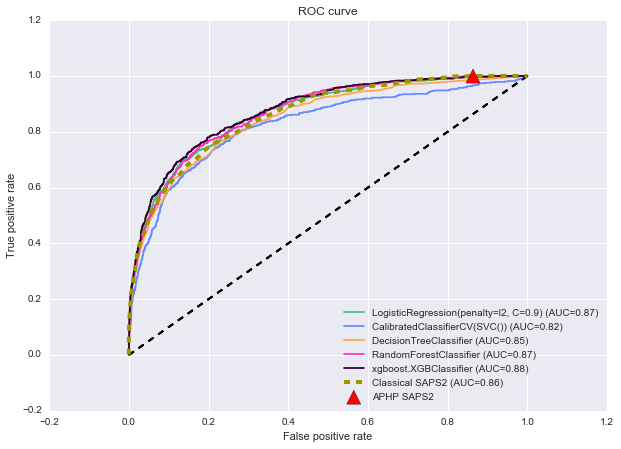

In [47]:
from sklearn.metrics import roc_curve

roc_curves_4_clfs(clfs, X_valid, y_valid, labels)

# plot ROC curve for classical SAPS2
fpr, tpr, thresholds = roc_curve(y_valid, resultf_valid['pr'])
ras = roc_auc_score(y_valid, resultf_valid['pr'])
plt.plot(fpr, tpr, label="Classical SAPS2" + " (AUC={0:.2f})".format(ras), color='#999900', linewidth=4, linestyle='--')

# Find discrete APHP classifier location
aphp_saps2_index = np.where(thresholds == pr)
aphp_fpr = fpr[aphp_saps2_index]
aphp_tpr = tpr[aphp_saps2_index]
# plt.plot([aphp_fpr], [aphp_tpr], 'ro', linewidth=20, label="APHP SAPS2")
plt.scatter(aphp_fpr, aphp_tpr, c='r', s=200, label="APHP SAPS2", zorder=10, marker = '^')

plt.legend(loc='best');

In [48]:
l_counters = ['DIURESE', 'GLASGOW', 'PAO2/FIO2', 'PRESSIONARTERIELLE']
for f in l_counters:
    cpt_name = 'C_'+f
    X[cpt_name] = X.groupby(f)[f].transform('count')
    sq_name = 'SQ_'+f
    X[sq_name] = np.sqrt(X[f].astype(float))
    ln_name = 'LN_'+f
    X[ln_name] = np.log(X[f].astype(float)+1.)

X.head()

,TYPEADMISSION,AGE,BICARBONATEMIE,BILIRUBINE,DIURESE,FREQUENCECARDIAQUE,GLASGOW,GLOBULESBLANCS,KALIEMIE,NATREMIE,...,LN_DIURESE,C_GLASGOW,SQ_GLASGOW,LN_GLASGOW,C_PAO2/FIO2,SQ_PAO2/FIO2,LN_PAO2/FIO2,C_PRESSIONARTERIELLE,SQ_PRESSIONARTERIELLE,LN_PRESSIONARTERIELLE
0,6,12,0,0,0,0,13,0,0,0,...,0.000000,519,3.605551,2.639057,3214,2.44949,1.94591,3714,2.236068,1.791759
1,6,18,0,0,0,0,0,0,0,0,...,0.000000,11004,0.000000,0.000000,9298,0.00000,0.00000,8671,0.000000,0.000000
2,6,16,3,0,4,4,5,3,0,0,...,1.609438,1265,2.236068,1.791759,3214,2.44949,1.94591,1950,3.605551,2.639057
3,6,12,3,0,4,4,0,3,0,0,...,1.609438,11004,0.000000,0.000000,9298,0.00000,0.00000,3714,2.236068,1.791759
4,6,18,3,0,11,0,7,0,3,0,...,2.484907,429,2.645751,2.079442,9298,0.00000,0.00000,1950,3.605551,2.639057


In [49]:
# Separate train / validation
X_train, y_train, X_valid, y_valid, valid_indices = cu.split_dataset(X.values, y_true, indices=True)

# Retrieve related validation set from the resultf DataFrame
resultf_valid = resultf.ix[valid_indices, :]
yf_pred = resultf_valid['pr'] > pr

In [50]:
for i, clf in enumerate(clfs):
    print labels[i]
    print("Cross validation, accuracies")
    print(cu.cross_valid_clf(clf, X_train, y_train))
    print("Validation set ==> accuracy + recall + precision + ROC/AUC score")
    print(cu.validate_clf(clf, X_train, y_train, X_valid, y_valid))
    print

LogisticRegression(penalty=l2, C=0.9)
Cross validation, accuracies
[ 0.88996434  0.89041794  0.88634047  0.89393167  0.89138195]
Validation set ==> accuracy + recall + precision + ROC/AUC score
(0.89726865063187933, 0.36793893129770994, 0.72809667673716016, 0.86252035892767043)

CalibratedClassifierCV(SVC())
Cross validation, accuracies
[ 0.87417219  0.8756371   0.88124363  0.88016318  0.88169301]
Validation set ==> accuracy + recall + precision + ROC/AUC score
(0.8846310640032613, 0.21832061068702291, 0.7258883248730964, 0.82119339679392911)

DecisionTreeClassifier
Cross validation, accuracies
[ 0.88639837  0.88583078  0.89092762  0.88067313  0.89291178]
Validation set ==> accuracy + recall + precision + ROC/AUC score
(0.89135752140236446, 0.29007633587786258, 0.73643410852713176, 0.84741803006387351)

RandomForestClassifier
Cross validation, accuracies
[ 0.89047376  0.88735984  0.8883792   0.89393167  0.89444161]
Validation set ==> accuracy + recall + precision + ROC/AUC score
(0.893

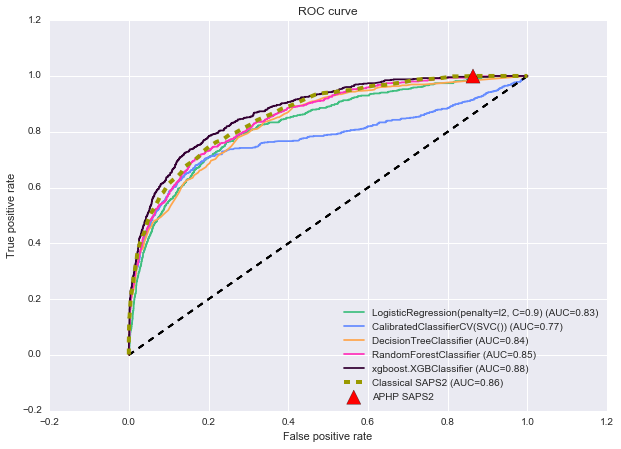

In [455]:
from sklearn.metrics import roc_curve

roc_curves_4_clfs(clfs, X_valid, y_valid, labels)

# plot ROC curve for classical SAPS2
fpr, tpr, thresholds = roc_curve(y_valid, resultf_valid['pr'])
ras = roc_auc_score(y_valid, resultf_valid['pr'])
plt.plot(fpr, tpr, label="Classical SAPS2" + " (AUC={0:.2f})".format(ras), color='#999900', linewidth=4, linestyle='--')

# Find discrete APHP classifier location
aphp_saps2_index = np.where(thresholds == pr)
aphp_fpr = fpr[aphp_saps2_index]
aphp_tpr = tpr[aphp_saps2_index]
# plt.plot([aphp_fpr], [aphp_tpr], 'ro', linewidth=20, label="APHP SAPS2")
plt.scatter(aphp_fpr, aphp_tpr, c='r', s=200, label="APHP SAPS2", zorder=10, marker = '^')

plt.legend(loc='best');

In [46]:
# clf = RandomForestClassifier(min_samples_leaf=40, n_estimators=200, n_jobs=-1)
clf = GradientBoostingClassifier(min_samples_leaf=40, n_estimators=200)
print(cu.cross_valid_clf(clf, X_train, y_train))
print(cu.validate_clf(clf, X_train, y_train, X_valid, y_valid))

[ 0.88741722  0.89194699  0.88990826  0.89750127  0.90158083]
(0.8958418263350999, 0.37709923664122136, 0.70571428571428574, 0.86776223286483101)


In [47]:
df_fi = pd.DataFrame(columns=['feature', 'importance'])
df_fi['feature'] = X.columns
df_fi['importance'] = clf.feature_importances_
df_fi.sort(['importance'], ascending=False)

,feature,importance
10,PAO2/FIO2,0.120621
1,AGE,0.120617
6,GLASGOW,0.111615
5,FREQUENCECARDIAQUE,0.077092
2,BICARBONATEMIE,0.071199
14,MALADIESCHRONIQUES,0.068403
11,PRESSIONARTERIELLE,0.066613
4,DIURESE,0.062685
0,TYPEADMISSION,0.060764
3,BILIRUBINE,0.056832


In [48]:
clf = RandomForestClassifier(min_samples_leaf=50, n_estimators=200, n_jobs=-1)
print(cu.cross_valid_clf(clf, X_train, y_train))
print(cu.validate_clf(clf, X_train, y_train, X_valid, y_valid))
df_fi = pd.DataFrame(columns=['feature', 'importance'])
df_fi['feature'] = X.columns
df_fi['importance'] = clf.feature_importances_
df_fi.sort(['importance'], ascending=False)

[ 0.8828324   0.88685015  0.88481142  0.88526262  0.88577257]
(0.88993069710558503, 0.2381679389312977, 0.79187817258883253, 0.85657779669265066)


,feature,importance
6,GLASGOW,0.202279
11,PRESSIONARTERIELLE,0.199208
10,PAO2/FIO2,0.153383
4,DIURESE,0.123695
2,BICARBONATEMIE,0.074966
5,FREQUENCECARDIAQUE,0.073264
13,UREE,0.050887
1,AGE,0.049030
14,MALADIESCHRONIQUES,0.029719
8,KALIEMIE,0.015329


In [49]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=200)
print(cu.cross_valid_clf(clf, X_train, y_train))
print(cu.validate_clf(clf, X_train, y_train, X_valid, y_valid))
df_fi = pd.DataFrame(columns=['feature', 'importance'])
df_fi['feature'] = X.columns
df_fi['importance'] = clf.feature_importances_
df_fi.sort(['importance'], ascending=False)

[ 0.88894549  0.89449541  0.88888889  0.89342172  0.90107088]
(0.89400733795352627, 0.36488549618320609, 0.69679300291545188, 0.86763527575909405)


,feature,importance
5,FREQUENCECARDIAQUE,0.190
7,GLOBULESBLANCS,0.145
6,GLASGOW,0.120
1,AGE,0.085
10,PAO2/FIO2,0.085
11,PRESSIONARTERIELLE,0.085
14,MALADIESCHRONIQUES,0.085
13,UREE,0.070
4,DIURESE,0.040
0,TYPEADMISSION,0.025


In [50]:
# from sklearn.neural_network import BernoulliRBM
# from sklearn.pipeline import Pipeline

# logistic = LogisticRegression()
# rbm = BernoulliRBM(random_state=0, verbose=True)
# clf = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])
# print(cu.cross_valid_clf(clf, X_train, y_train))
# print(cu.validate_clf(clf, X_train, y_train, X_valid, y_valid))
# df_fi = pd.DataFrame(columns=['feature', 'importance'])
# df_fi['feature'] = X.columns
# df_fi['importance'] = clf.feature_importances_
# df_fi.sort(['importance'], ascending=False)

In [51]:
# clf.coef_

In [52]:
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier

# clf = ExtraTreesClassifier(min_samples_leaf=50, n_estimators=400, n_jobs=-1)
clf = BaggingClassifier(n_estimators=1000, n_jobs=-1)
# print(cu.cross_valid_clf(clf, X_train, y_train))
print(cu.validate_clf(clf, X_train, y_train, X_valid, y_valid))
# df_fi = pd.DataFrame(columns=['feature', 'importance'])
# df_fi['feature'] = X.columns
# df_fi['importance'] = clf.coef_
# df_fi.sort(['importance'], ascending=False)

(0.88483489604565835, 0.40305343511450381, 0.60273972602739723, 0.83580334039049642)


In [60]:
clf = xgb.XGBClassifier(max_depth=3, n_estimators=70, min_child_weight=3.8, base_score=0.5, colsample_bytree=0.8,
                           colsample_bylevel=1, subsample=1, scale_pos_weight=1)
print(cu.cross_valid_clf(clf, X_train, y_train))
print(cu.validate_clf(clf, X_train, y_train, X_valid, y_valid))

[ 0.89302089  0.88990826  0.89143731  0.8954615   0.90464049]
(0.89604565837749695, 0.33740458015267177, 0.74410774410774416, 0.87530836929254185)


In [418]:
df_fi = pd.DataFrame(columns=['feature', 'importance'])
df_fi['feature'] = X.columns
df_fi['importance'] = clf.feature_importances_
df_fi.sort(['importance'], ascending=False)

,feature,importance
1,AGE,0.178849
14,MALADIESCHRONIQUES,0.118196
6,GLASGOW,0.085537
5,FREQUENCECARDIAQUE,0.069984
0,TYPEADMISSION,0.055988
21,C_PAO2/FIO2,0.052877
10,PAO2/FIO2,0.045101
13,UREE,0.045101
2,BICARBONATEMIE,0.041991
3,BILIRUBINE,0.040435
